<h1 style="text-align:center;">Basic Data Analysis</h1>

## Table of contents:
* [Intro](#sec-intro)
* [Prior hypothesis](#sec-hypoth)
* [Notebook imports](#sec-imports)
* [Analysis](#alys)
    * [Dispersity of prices](#alys-disp)
    * [Vehicles](#alys-vehic)
    * [Reviews](#alys-rev)

<h2 id="sec-intro">Intro</h2>

Here we will take a look at some basic data trends and interesting correlations from the data. We will take a look at the dispersity of prices, the influence of vehicle possession on the median price of the services and the reviews. 

<h2 id="sec-hypoth">Prior hypothesis</h2>


<h2 id="sec-imports">Notebook imports</h2>


In [25]:
import sqlite3
import pandas as pd
import matplotlib
matplotlib.use
import matplotlib.pyplot as plt


<h2 id="alys">Analysis</h2>

Here we will take a look at some basic data trends and interesting correlations.

<h4 id="alys-disp">Dispersity of price</h4>

First let's take a look at the dispersity of the price for each service in, say, los angeles. Before chosing an appropriate measure of dispersion, we must take a look at the skewness by plotting a histogram. So let's grab the data from the database and plot our histograms nicely. First we set the city variable to the key of the city we want to get info from (remember, to view the full list of keys you can access [blops]("xd")):

In [26]:
city = "ny"

And now we plot the histograms:

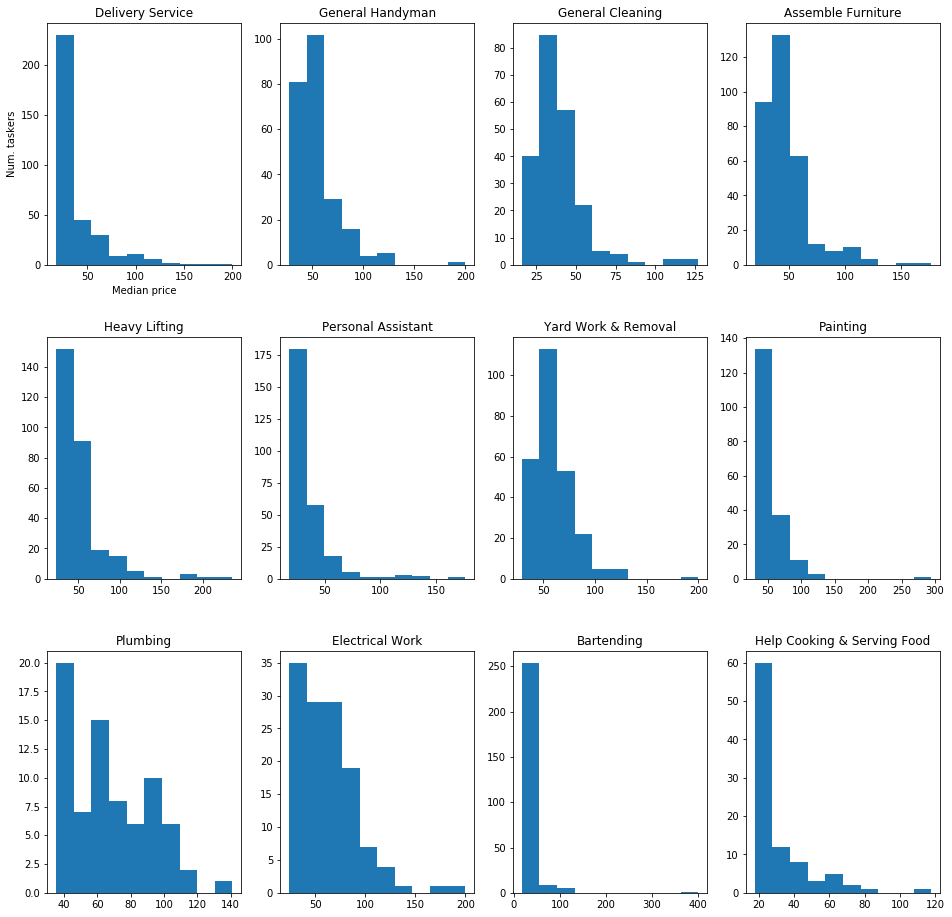

In [45]:
#Create connection to database of city
conn = sqlite3.connect('../databases/taskrabbit_' + city + '.db')
c = conn.cursor()

#Get the services of the database
c.execute("SELECT service_id, name FROM services;")
services = [(row[0], row[1]) for i, row in enumerate(c.fetchall())]

#Create our "grid plot"
fig_original = plt.figure(figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

#fig_original.suptitle('Histogram of prices within each service in ' + city, fontsize=12)
columns, rows = 4, 3

#Our dictionary of service dataframes
dfs = {}

#Pretty plot into a grid like figure
for i in range(1, columns * rows + 1):
    c.execute("SELECT price_details.amount FROM descriptions,taskers,services,price_details WHERE descriptions.tasker_id = taskers.tasker_id AND services.service_id = descriptions.service_id AND Taskers.tasker_id = price_details.tasker_id AND  price_details.service_id = services.service_id AND services.service_id = " + str(services[i - 1][0]) + ";")

    df_data = {"price": [row[0] for row in c.fetchall()]}
    ax1 = fig_original.add_subplot(rows, columns, i)
    ax1.hist(df_data["price"])
    ax1.set_title(services[i - 1][1])
    ax1.get_yaxis().set_visible(True)
    if i == 1:
        ax1.set_xlabel("Median price\n")
        ax1.set_ylabel("Num. taskers")
    #ax1.set_xlabel(services[i - 1][1])
    ax1.get_xaxis().set_visible(True)
    
    df = pd.DataFrame(df_data, index=[i for i in range(0, len(df_data["price"]))])
    dfs[services[i - 1][1]] = df
    
fig_original.savefig('foo.png')

From the plot above we can see that data for the price of the services is for the most part, very skewed. This means we should probably not use standard deviation as it is inappropriate for measuring dispersion in skewed data. Instead we are going to find the median absolute deviation (MAD) for each of the services we are evaluating. First let us define a function to calculate the MAD of a dataframe column.

In [43]:
def MAD(X):
    return abs(X - X.median()).median()

And now for the fun matplotlib table plotting...

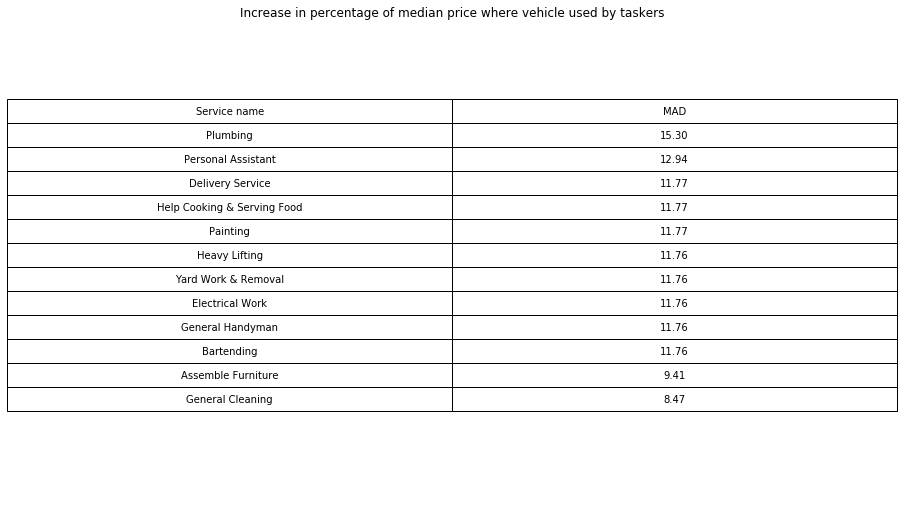

In [44]:
#Prepare plot
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
ax.axis('off')
ax.axis('tight')
fig.tight_layout()
plt.title("Increase in percentage of median price where vehicle used by taskers")

#The dataframe we need for plotting our table
disp_data = {
    "Service name": [service[1] for service in services],
    "MAD": [MAD(dfs[service_name]["price"]) for service_name in dfs.keys()],
}
table_disp = pd.DataFrame(disp_data, index=[i for i in range(0, len(services))])

#Sort in descending order of MAD and format
table_disp.sort_values(by='MAD', ascending=False, inplace=True)
table_disp["MAD"] = ['%1.2f' % val for val in table_disp["MAD"]]

#Create table, resize
t = ax.table(cellText=table_disp.values, colLabels=table_disp.columns, loc='center', cellLoc='center')
t.scale(2, 2)

<h4 id="alys-vehic">Vehicle analysis</h4>

We explore the influence of taskers having vehicles with the median price of the service they offer across locations in a city. The module <i>vehicle_analysis</i> takes in as argument the name of the city for which we want to plot some diagrams. 

Let's take a look at los angeles by running the code below:

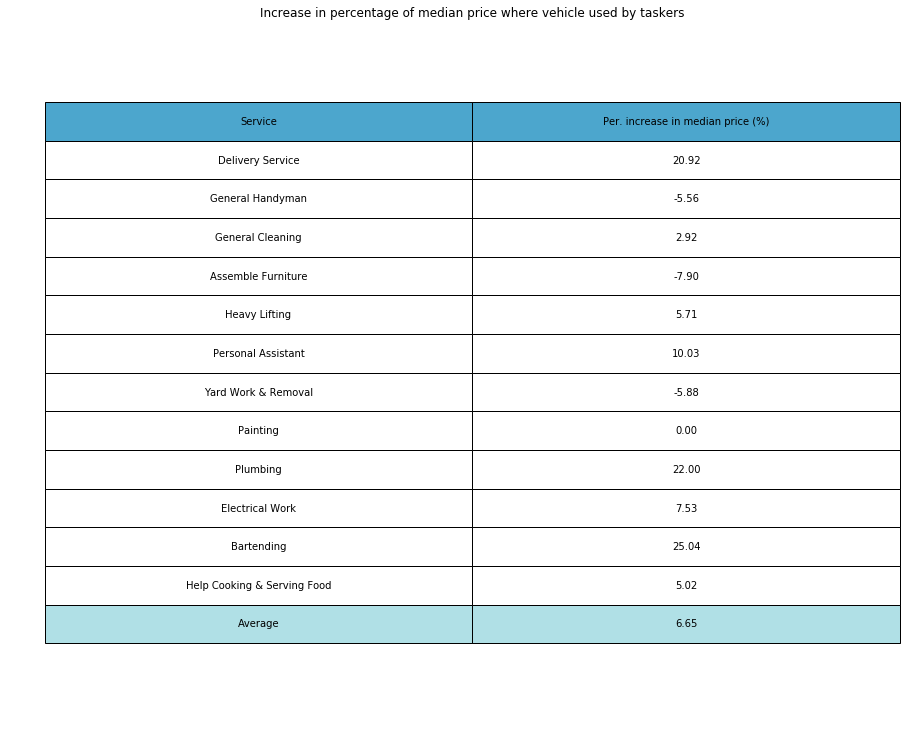

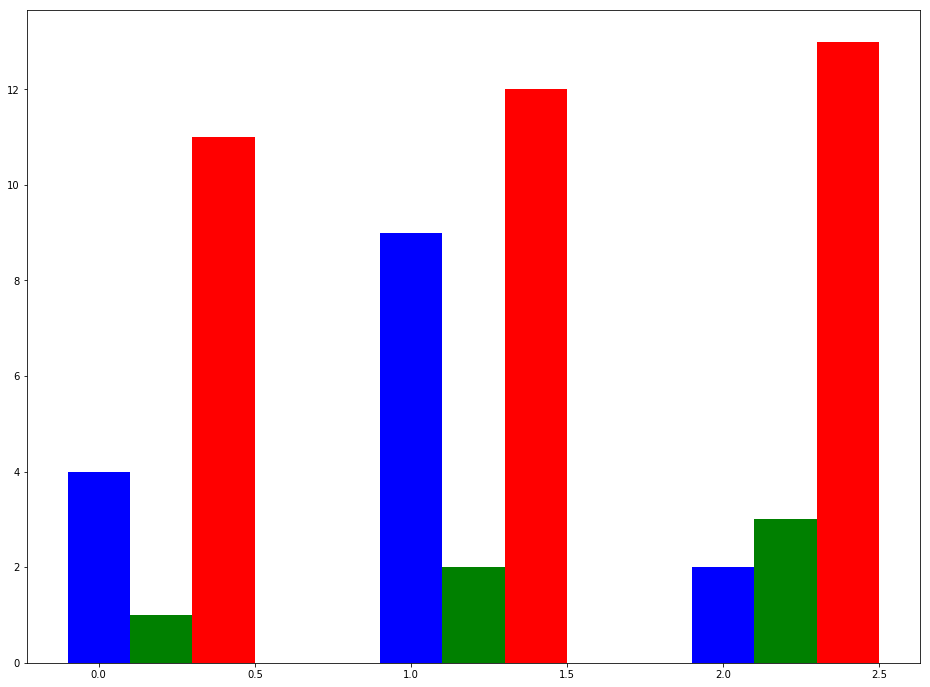

In [64]:
%run -i 'analysis/vehicle_analysis.py' "taskrabbit_ny.db" "new_york"

We can see that the average percentage increase in median price of the services scraped when taskers have vehicles is 6.95%. It is consistent across all cities scraped, that the percentage change in median price across services when taskers have at least one vehicle is positive, which confirms the hypothesis that having a vehicle give higher value to the service taskers can offer.

Additionally, it is worth noting that the service with the highest percentage increase in median price was the Delivery Service (as can be seen from the graphs above), which makes sense considering it is the most vehicle-dependent service from the selection scraped.

Now let us take a look at the number of taskers which have a vehicle in New York. The map below plots exactly that (the white areas missing are zip codes which I had to ignore for lack of data availability either in the census data or within TaskRabbit).

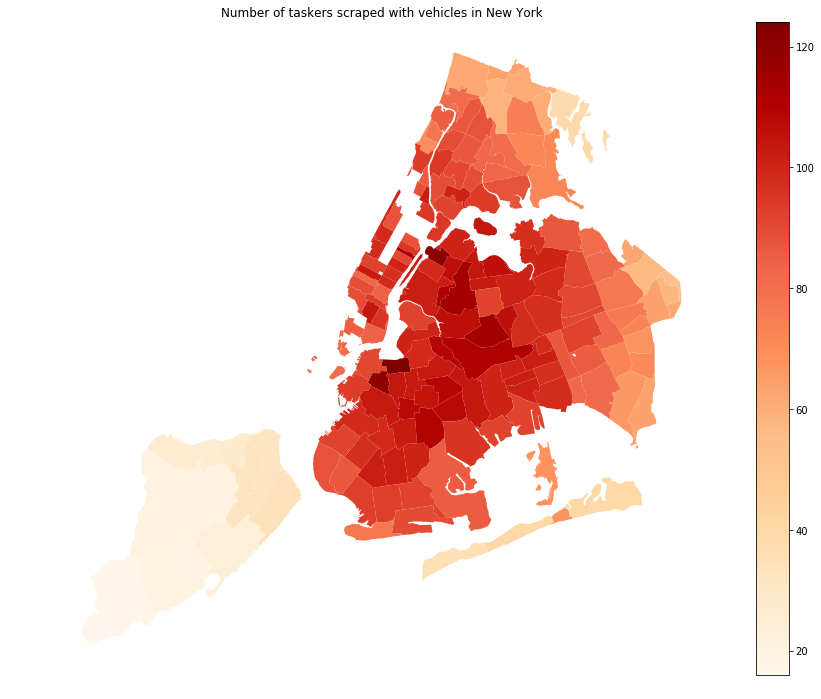

In [46]:
%run -i 'analysis/state_boundaries.py' 'taskers_with_vehicles' 'ny'

The map basically tells us that the area of Brooklyn and Queens seem to be the ones where more taskers offer vehicles with their services. Nevertheless, this are also the two most populated boroughs of New York, along with being the two boroughs with the most taskers from the ones we scraped. So now we take a look at the same map but in proportion to the number of taskers that were scraped for that particular postcode (so we can think of it as, number of taskers with a vehicle per taskers in the area):

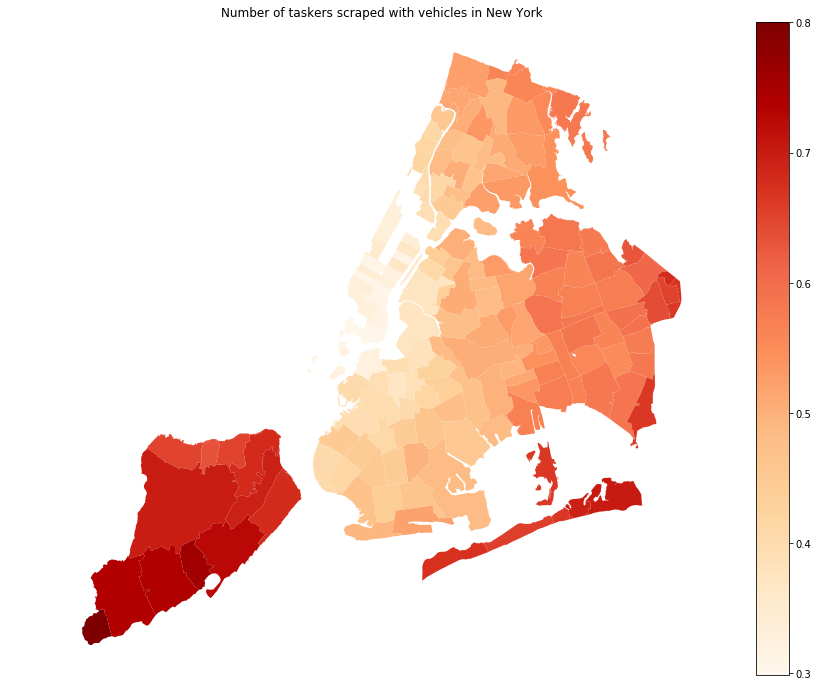

In [47]:
%run -i 'analysis/state_boundaries.py' 'taskers_with_vehicles_prop' 'ny'

From the looks of it, now it appears like in proportion to the number of taskers, postcodes in Staten Island seem to have the most taskers offering vehicles with their services. This is followed by Queens, and with Manhattan postcodes having the lowest values. This makes sense when compared to this article: https://www.nycedc.com/blog-entry/new-yorkers-and-their-cars which states that car ownership in Manhattan is lowest while Staten Island has the most car ownership followed by Queens.

<h4 id="alys-rev">Reviews</h4>

After scraping the reviews, we clearly see that TaskRabbit is most likely filtering out the taskers with more negative reviews, and only displaying in the 50 results those taskers that are both closer to you AND have a very high percentage of positive reviews.

Below we can see the percentage of positive and negative reviews across all services for Los Angeles:

In [48]:
c.execute("SELECT * FROM reviews;")
reviews = list(c.fetchall())
print (sum([1 if review[3] == "positive" else 0 for review in reviews])/len(reviews))

0.9813642756680732
